In [106]:
import nbsetup
import pymc3 as pm
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from models.sparc.result import Result

In [107]:
default = Result()

In [151]:
df = default.datasets()['Quality Thresholded']

In [117]:
coords = {
    "galaxy": df.ID.unique(),
    "observation": df.Vobs.index
}

# using the sparc values as the 
sparc = df.groupby('ID').mean()[['Inc', 'e_Inc', 'D', 'e_D']]

with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 200)
    alpha = pm.Uniform('alpha', 0, 1)
    
    # Error
    sigma = pm.HalfCauchy("sigma", beta=5, dims="observation")
    
    # Galaxy priors
    DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
    inc = DegreesNormal('Inc', mu=sparc['Inc'], sigma=sparc['e_Inc'], dims='galaxy')
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    dist = PositiveNormal('D', mu=sparc['D'], sigma=sparc['e_D'], dims='galaxy')
    #if use_tau: tau = pm.Exponential('tau', 1)
    tau = 0

    # Data
    force = pm.Data("force", df.Fnewton, dims="observation")
    radius = pm.Data("radius", df.R, dims="observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="observation")
    sparc_d = pm.Data("sparc_distance", df.D, dims="observation")
    sparc_inc = pm.Data("sparc_inc", df.Inc, dims="observation")
    g = pm.Data("g", df.gidx, dims="observation")
    
    # Prediction model
    # adjust for nulled field
    ftd = force*(gamma/(1+(nulled)**alpha))
    # adjust r for distance when calc V
    vtd = np.sqrt(ftd*radius*dist[g]/sparc_d[g])
    # adjust the predicition for inclination of Vobs
    vpred = vtd*np.sin(inc[g]*np.pi/180)/np.sin(sparc_inc[g]*np.pi/180)
    
    # Define likelihood
    obs = pm.Normal("obs", mu=vpred, sigma=sigma, observed=df.Vobs, dims="observation")

In [135]:
start['gamma']

array(99.79540842)

In [119]:
with galaxy_model:
    start = pm.find_MAP()
    gal_trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, target_accept=0.9, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D, Inc, sigma, alpha, gamma]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 349 seconds.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [145]:
gamma.trace()

ValueError: ('ExtractDiag needs an input with 2 or more dimensions', gamma ~ Uniform)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='alpha', ylabel='gamma'>, <AxesSubplot:>]],
      dtype=object)

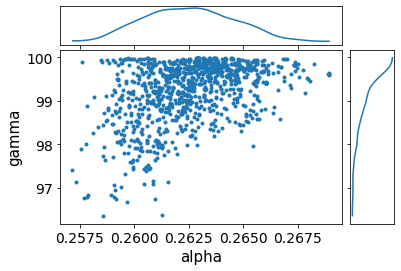

In [148]:
az.plot_pair(gal_trace, var_names=['alpha','gamma'], marginals=True)

In [137]:
az.summary(gal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma,99.233,0.691,97.936,99.996,0.070,0.050,102.0,128.0,1.02
alpha,0.263,0.002,0.259,0.266,0.000,0.000,25.0,46.0,1.09
sigma[1],30.258,47.265,6.628,60.747,4.483,3.178,194.0,156.0,1.02
sigma[2],35.848,31.521,8.425,91.642,2.485,1.760,161.0,150.0,1.01
sigma[3],57.774,117.712,8.489,136.423,9.476,6.713,150.0,153.0,1.00
...,...,...,...,...,...,...,...,...,...
D[UGC12632],20.450,1.816,17.266,23.799,0.233,0.169,66.0,118.0,1.03
D[UGC12732],26.350,2.205,21.991,30.229,0.178,0.127,156.0,226.0,1.03
D[UGCA281],5.783,0.247,5.358,6.264,0.020,0.014,142.0,263.0,1.01
D[UGCA442],4.428,0.223,3.945,4.777,0.016,0.012,184.0,258.0,1.02


In [140]:
az.summary(gal_trace[500:][500:][500:])

KeyError: slice(500, None, None)

In [130]:
dir(gal_trace.posterior)

['D',
 'Inc',
 '_HANDLED_TYPES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__par

In [132]:
gal_trace.posterior['D']

<xarray.DataArray 'D' (chain: 2, draw: 500, galaxy: 138)>
array([[[2.94628776, 1.17684949, 3.43062307, ..., 6.17985172,
         4.26602177, 0.91452197],
        [2.87273904, 1.20003743, 3.52331427, ..., 6.24151628,
         4.09705225, 0.95407465],
        [2.8619897 , 1.20034601, 3.49191442, ..., 6.27061102,
         4.11798064, 0.95826176],
        ...,
        [3.30452751, 1.03486113, 3.71084052, ..., 5.95244541,
         4.32605438, 1.07507793],
        [3.20713493, 0.97016877, 3.83527839, ..., 5.8572496 ,
         4.59928494, 1.04453309],
        [3.08296121, 1.05237263, 3.80277997, ..., 5.83236158,
         4.47139216, 1.04954128]],

       [[3.00959484, 1.20787135, 3.60459213, ..., 5.86439463,
         4.41007117, 1.03656293],
        [2.86770676, 1.15443412, 3.6623503 , ..., 5.81801958,
         4.36085593, 0.99704986],
        [3.06286803, 1.17525621, 3.68573556, ..., 5.95435465,
         4.32360443, 1.00695057],
        ...,
        [3.17209716, 0.99493509, 3.96936007, ..., 5.52392936,
         3.98532857, 1.22140818],
        [2.49227326, 1.09939469, 3.93469696, ..., 5.66902721,
         4.01514189, 1.13013017],
        [3.42964358, 1.05039975, 3.66432278, ..., 5.83552451,
         4.24978648, 1.01502455]]])
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * galaxy   (galaxy) object 'CamB' 'DDO064' 'DDO154' ... 'UGCA442' 'UGCA444'

In [122]:
from references.sparc import adjustment_df
adjs = adjustment_df()

ImportError: cannot import name 'adjustment_df' from 'references.sparc' (/Users/timjdavey/Projects/darkness/relativity/notebooks/../references/sparc.py)